# **Continuous Evaluation**

### ***Loading Libraries***

In [1]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.5 MB/s eta 0:00:00


In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [4]:
!pip install hypertune

In [5]:
# Operating Systems
import os
import shutil
import pathlib
import argparse


# Numerical Computing
import numpy as np

# Data Manipuation
import pandas as pd

# SciPy
import scipy
from scipy import stats
from scipy import signal
from scipy.io import wavfile

# Data Visualization
import itertools
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

# Tabulate
from tabulate import tabulate

# Hyperparameter Tuning
import hypertune

# Tools
from setuptools import setup
from setuptools import find_packages

# BigQuery
from google.cloud import bigquery
from google.colab import auth

# Scikit-Learn
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support as score

# Extreme Gradient Boosting
import xgboost as xgb

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tensorflow_hub import KerasLayer
from tensorflow import feature_column as fc
from tensorflow.python.framework import dtypes
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical
from tensorflow_io.bigquery import BigQueryClient
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D, Lambda

# Keras API
import kerastuner as kt

<ipython-input-5-941eb135a369>:80: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [6]:
print(tf.__version__)

%matplotlib inline

2.15.0


## **Set-Up**

In [7]:
PROJECT = 'munn-sandbox'

BUCKET = 'munn-sandbox'

In [8]:
os.environ['BUCKET'] = BUCKET

os.environ['PROJECT'] = PROJECT

os.environ['TFVERSION'] = '2.1'

In [9]:
# User Authentication
auth.authenticate_user()

# BigQuery Library
# !pip install --upgrade google-cloud-bigquery

In [10]:
project_id = 'core-catalyst-425922-v9'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

# BigQuery Client Config
client = bigquery.Client(project=project_id)

### ***Model Training & Deployment***

In [12]:
DATASET_NAME = "titles_full.csv"
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(DATASET_NAME, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,attempts to fix hn comment problems,techcrunch
1,stop trusting yourself,nytimes
2,scrollability,github
3,toward our 3d future,techcrunch
4,open source mechanical split flap display,github


In [13]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [14]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [15]:
encode_labels(titles_df.source[:4])

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [16]:
N_TRAIN = int(len(titles_df) * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [17]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)

X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [18]:
X_train[:3]

array(['attempts to fix hn comment problems ', 'stop trusting yourself',
       'scrollability'], dtype=object)

###  ***Swivel Model***

In [19]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"

swivel_module = KerasLayer(SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

In [20]:
def build_model(hub_module, model_name):
    inputs = Input(shape=[], dtype=tf.string, name="text")
    module = hub_module(inputs)
    h1 = Dense(16, activation='relu', name="h1")(module)
    outputs = Dense(N_CLASSES, activation='softmax', name='outputs')(h1)
    model = Model(inputs=inputs, outputs=[outputs], name=model_name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [21]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    tf.random.set_seed(33)
    X_train, Y_train = train_data

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping()],
    )
    return history

In [22]:
txtcls_model = build_model(swivel_module, model_name='txtcls_swivel')

In [23]:
txtcls_model.summary()

Model: "txtcls_swivel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 20)                389380    
                                                                 
 h1 (Dense)                  (None, 16)                336       
                                                                 
 outputs (Dense)             (None, 3)                 51        
                                                                 
Total params: 389767 (1.49 MB)
Trainable params: 389767 (1.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### ***Model Training & Evaluation***

In [24]:
train_data = (X_train, Y_train)

val_data = (X_valid, Y_valid)

In [25]:
txtcls_history = train_and_evaluate(train_data, val_data, txtcls_model)

Epoch 1/100
16/16 [==============================] - 6s 194ms/step - loss: 1.1629 - accuracy: 0.3905 - val_loss: 1.1060 - val_accuracy: 0.4199
Epoch 2/100
16/16 [==============================] - 3s 172ms/step - loss: 1.0671 - accuracy: 0.4493 - val_loss: 1.0336 - val_accuracy: 0.4742
Epoch 3/100
16/16 [==============================] - 2s 127ms/step - loss: 1.0052 - accuracy: 0.5009 - val_loss: 0.9837 - val_accuracy: 0.5173
Epoch 4/100
16/16 [==============================] - 3s 216ms/step - loss: 0.9590 - accuracy: 0.5403 - val_loss: 0.9430 - val_accuracy: 0.5540
Epoch 5/100
16/16 [==============================] - 2s 154ms/step - loss: 0.9186 - accuracy: 0.5709 - val_loss: 0.9058 - val_accuracy: 0.5818
Epoch 6/100
16/16 [==============================] - 2s 116ms/step - loss: 0.8801 - accuracy: 0.5989 - val_loss: 0.8693 - val_accuracy: 0.6080
Epoch 7/100
16/16 [==============================] - 2s 128ms/step - loss: 0.8417 - accuracy: 0.6238 - val_loss: 0.8325 - val_accuracy: 0.6290

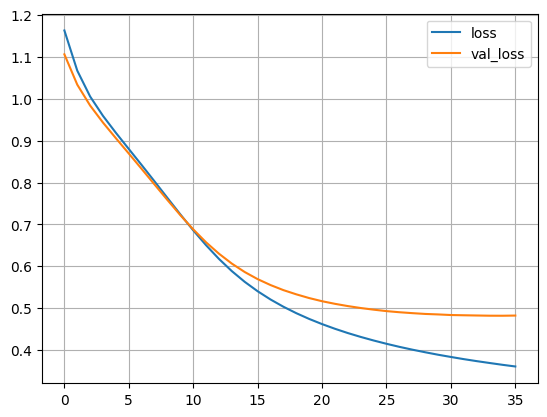

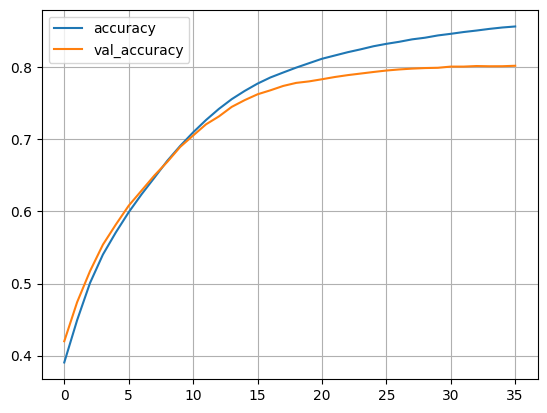

In [28]:
history = txtcls_history

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)
plt.show()

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)
plt.show()

In [29]:
txtcls_model.predict(x=["YouTube introduces Video Chapters to make it easier to navigate longer videos"])

1/1 [==============================] - 0s 128ms/step


array([[0.08974307, 0.8439801 , 0.06627692]], dtype=float32)

In [30]:
tf.saved_model.save(txtcls_model, './txtcls_swivel/')

In [31]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./txtcls_swivel/

2024-06-22 18:53:25.083643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 18:53:25.083700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 18:53:25.084912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-22 18:53:26.217979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):


In [32]:
@tf.function(input_signature=[tf.TensorSpec([None], dtype=tf.string)])
def source_name(text):
    labels = tf.constant(['github', 'nytimes', 'techcrunch'], dtype=tf.string)
    probs = txtcls_model(text, training=False)
    indices = tf.argmax(probs, axis=1)
    pred_source = tf.gather(params=labels, indices=indices)
    pred_confidence = tf.reduce_max(probs, axis=1)

    return {'source': pred_source,
            'confidence': pred_confidence}

In [33]:
shutil.rmtree('./txtcls_swivel', ignore_errors=True)

txtcls_model.save('./txtcls_swivel', signatures={'serving_default': source_name})

In [34]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./txtcls_swivel/

2024-06-22 18:53:36.981569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 18:53:36.981623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 18:53:36.982753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-22 18:53:38.007809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):


In [35]:
title1 = "House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force"
title2 = "YouTube introduces Video Chapters to make it easier to navigate longer videos"
title3 = "As facebook turns 10  zuckerberg wants to change how tech industry works"

restored = tf.keras.models.load_model('./txtcls_swivel')
infer = restored.signatures['serving_default']
outputs = infer(text=tf.constant([title1, title2, title3]))

In [36]:
print(outputs['source'].numpy())
print(outputs['confidence'].numpy())

[b'github' b'nytimes' b'techcrunch']
[0.97954845 0.8439801  0.89969945]


### ***Online Serving Model Deployment***

In [38]:
%%bash
MODEL_NAME="txtcls"
MODEL_VERSION="swivel"
MODEL_LOCATION="./txtcls_swivel/"

gcloud ai-platform models create ${MODEL_NAME}

gcloud ai-platform versions create ${MODEL_VERSION} \
--model ${MODEL_NAME} \
--origin ${MODEL_LOCATION} \
--staging-bucket gs://${BUCKET} \
--runtime-version=2.1

## **Evaluation job on CAIP Set-Up**

In [ ]:
%load_ext google.cloud.bigquery

In [ ]:
%%bigquery --project $PROJECT
SELECT * FROM `txtcls_eval.swivel`

## **Sending Prediction Requests to The Model**

In [ ]:
%%writefile input.json
{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}

In [ ]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

In [ ]:
%%writefile input.json
{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}

In [ ]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

In [ ]:
%%writefile input.json
{"text": "A native Mac app wrapper for WhatsApp Web"}

In [ ]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

In [ ]:
%%writefile input.json
{"text": "Astronauts Dock With Space Station After Historic SpaceX Launch"}

In [ ]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

In [ ]:
%%writefile input.json
{"text": "House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force"}

In [ ]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

In [ ]:
%%writefile input.json
{"text": "Scrollability"}

In [ ]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

In [ ]:
%%writefile input.json
{"text": "iOS 14 lets deaf users set alerts for important sounds, among other clever accessibility perks"}

In [ ]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

In [ ]:
%%bigquery --project $PROJECT
SELECT * FROM `txtcls_eval.swivel`

## **Providing Ground Truth's Raw Prediction Input**

In [ ]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET
    groundtruth = '{"predictions": [{"source": "techcrunch"}]}'
WHERE
    raw_data = '{"instances": [{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}]}';

In [ ]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET
    groundtruth = '{"predictions": [{"source": "nytimes"}]}'
WHERE
    raw_data = '{"instances": [{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}]}';

In [ ]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET
    groundtruth = '{"predictions": [{"source": "github"}]}'
WHERE
    raw_data = '{"instances": [{"text": "A native Mac app wrapper for WhatsApp Web"}]}';

In [ ]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET
    groundtruth = '{"predictions": [{"source": "nytimes"}]}'
WHERE
    raw_data = '{"instances": [{"text": "Astronauts Dock With Space Station After Historic SpaceX Launch"}]}';

In [ ]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET
    groundtruth = '{"predictions": [{"source": "nytimes"}]}'
WHERE
    raw_data = '{"instances": [{"text": "House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force"}]}';

In [ ]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET
    groundtruth = '{"predictions": [{"source": "github"}]}'
WHERE
    raw_data = '{"instances": [{"text": "Scrollability"}]}';

In [ ]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET
    groundtruth = '{"predictions": [{"source": "techcrunch"}]}'
WHERE
    raw_data = '{"instances": [{"text": "iOS 14 lets deaf users set alerts for important sounds, among other clever accessibility perks"}]}';

In [ ]:
%%bigquery --project $PROJECT
SELECT * FROM `txtcls_eval.swivel`

## **Computing Evaluation Metrics**

In [ ]:
%%bigquery --project $PROJECT
SELECT
  model,
  model_version,
  time,
  REGEXP_EXTRACT(raw_data, r'.*"text": "(.*)"') AS text,
  REGEXP_EXTRACT(raw_prediction, r'.*"source": "(.*?)"') AS prediction,
  REGEXP_EXTRACT(raw_prediction, r'.*"confidence": (0.\d{2}).*') AS confidence,
  REGEXP_EXTRACT(groundtruth, r'.*"source": "(.*?)"') AS groundtruth,
FROM
  `txtcls_eval.swivel`

In [ ]:
query = '''
SELECT
  model,
  model_version,
  time,
  REGEXP_EXTRACT(raw_data, r'.*"text": "(.*)"') AS text,
  REGEXP_EXTRACT(raw_prediction, r'.*"source": "(.*?)"') AS prediction,
  REGEXP_EXTRACT(raw_prediction, r'.*"confidence": (0.\d{2}).*') AS confidence,
  REGEXP_EXTRACT(groundtruth, r'.*"source": "(.*?)"') AS groundtruth,
FROM
  `txtcls_eval.swivel`
'''

client = bigquery.Client()
df_results = client.query(query).to_dataframe()

In [ ]:
df_results.head(20)

In [ ]:
prediction = list(df_results.prediction)
groundtruth = list(df_results.groundtruth)

In [ ]:
precision, recall, fscore, support = score(groundtruth, prediction)

In [ ]:
sources = list(CLASSES.keys())
results = list(zip(sources, precision, recall, fscore, support))
print(tabulate(results, headers = ['source', 'precision', 'recall', 'fscore', 'support'],
         tablefmt='orgtbl'))

In [ ]:
print(classification_report(y_true=groundtruth, y_pred=prediction))

In [ ]:
cm = confusion_matrix(groundtruth, prediction, labels=sources)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(sources)
ax.yaxis.set_ticklabels(sources)
plt.savefig("./txtcls_cm.png")

## ***Examine Eval Metrics by Model Version or Timestamp***

In [ ]:
now = pd.Timestamp.now(tz='UTC')
one_week_ago = now - pd.DateOffset(weeks=1)
one_month_ago = now - pd.DateOffset(months=1)

In [ ]:
df_prev_week = df_results[df_results.time > one_week_ago]
df_prev_month = df_results[df_results.time > one_month_ago]

In [ ]:
df_prev_month